# Fitting Gaussian Mixture Model with Expectatoin Maximization Algorithm

In this notebook, we implement the process of fitting Gaussian mixture models using the expectatoin maximization (EM) algorithm. 

Note : I have not followed any convergence proof of the EM algorithm, and do not know whether the parameter set obtained by the EM algorithm is indeed a local maximum. Hence, the treatment in the notebook is non rigoirous. 
It seems that the following paper discusses these points: 

Wu, C. F. Jeff (Mar 1983). "On the Convergence Properties of the EM Algorithm". Annals of Statistics. 11 (1): 95-103.
https://projecteuclid.org/euclid.aos/1176346060

In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import time

%matplotlib inline
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 1 Setting

Here we consider a unsupervised learning. 

* $N \in \mathbb{N}$ be the number of data points, and
* $d \in \mathbb{N}$ be the input dimension.
* Denote input data by $x_0, x_1, \dots , x_{N-1} \in \mathbb{R}^d$. 
* Denote the input data collectively by a matrix $X$, where $X_{n,i}$ is $i$-th component of $x_n$.




# 2 Theory 

Here we briefly summarize the analytical results needed. 
For the derivation, please see the book.

## 2.1 Model

a Gaussian mixture model with $K  \in \mathbb{N}$ components for the $N$ data points is defined by
$$
\begin{align}
    p\left(X,Z \middle| \mu, \Sigma, \pi \right) = 
    \prod_{n=0}^{N-1} \prod_{k=0}^{K-1} 
    \left[\pi_k \mathcal{N}\left(x_n \middle| \mu_k , \Sigma_k \right) \right]^{z_{n,k}}
\end{align}
$$
where 
* $Z = (z_{n,k})_{ n \in \{ 0, 1, \dots, N-1 \} k \in \{ 0,1, \dots, K-1 \}  }, \ z_{n,k}\in \{0,1 \}, \sum_{k=0}^{K-1}z_{n,k}=1$, is the matrix that stands for latent variables, 
* $\pi_k \geq 0, \sum_{k=0}^{K-1} \pi_k = 1$, and   
* $\mathcal{N}\left(x \middle| \mu_k , \Sigma_k \right)$ is a gaussian probability density with mean $\mu_k \in \mathbb{R}^d$ and covariance matrix $\Sigma_k$.

By summing over $Z$, we get

$$
\begin{align}
    p \left( X \middle| \mu, \Sigma, \pi \right) =
    \prod_{n=0}^{N-1} \left[ \sum_{k=0}^{K-1} \pi_k \mathcal{N}\left(x_n \middle| \mu_k, \Sigma_k \right)  \right]
\end{align}
$$

## 2.2 Goal

Our goal is to obtain a tuple of parameter $(\mu, \Sigma, \pi)$ which "maximizes" the likelihood $\log p(X|\mu, \Sigma, \pi)$. 

Note that, as was discussed in detail in Section 9.2.1 of the book, this maximization procedure is ill-posed, and hence we expect that we obtain a parameter set that locally maximizes the likelihood. 

## 2.3 Algorithm


1. Initialize parameters. 
2. E step : Calculate the responsibility $\gamma_{n,k}$ by 
$$
\begin{align}
    \gamma_{n,k} := \frac{ \pi_{k} \mathcal{N}\left(x_n \middle| \mu_k , \Sigma_k \right)   }{ \sum_{l=0}^{K-1} \pi_{l} \mathcal{N}\left(x_n \middle| \mu_l , \Sigma_l \right)  }
\end{align}
$$
3. M step : Using the responsibility obtained in the previous step, calculate the new parameters by 
$$
\begin{align}
    &{} N_k := \sum_{n=0}^{N-1} \gamma_{n,k} \\
    &{} \pi_k = \frac{N_k}{N}\\
    &{} \mu_k = \frac{1}{N_k} \sum_{n=0}^{N-1} \gamma_{n,k} x_n \\
    &{} \Sigma_k = \frac{1}{N_k} \sum_{n=0}^{N-1} \gamma_{n,k} (x_n-\mu_k)(x_n-\mu_k)^T  \\
\end{align}
$$
4. Repeat 2 and 3 until a predefined convergence criterion is met.

For a convergence criterion, we can use 
* the change of the parameter value
* the change of the log likelihood

as was stated in the book. Here we employ the latter; we terminate the iteration when the change of the log-likelihood
$$
\begin{align}
    \log p \left( X \middle| \mu, \Sigma, \pi \right) =
    \sum_{n=0}^{N-1} \log \left[ \sum_{k=0}^{K-1} \pi_k \mathcal{N}\left(x_n \middle| \mu_k, \Sigma_k \right)  \right]
\end{align}
$$
gets smaller than a predefined value.

# 3 From math to code

Here we show how we can convert the equations shown above into codes, emphasizing vectorized implementations.

We define a class `GaussianMixtureModel` representing Gaussian mixture models. 


## 3.1 Properties and methods

We give the class the following properties
* `K` : $K$, i.e., the number of components
* `Pi` : (K, ) array, where `Pi[k]` = $\pi_k$
* `Mu` : (K,d) array, where `Mu[k,i]` = $\mu_{k,i}$
* `Sigma` : (K, d, d) array, where `Sigma[k,i,j]` = $\left( \Sigma_{k} \right)_{i,j}$

We also give the class the following methods
* `_init_params` : method for initializing model parameters `Pi`, `Mu`, and `Sigma`.
* `_calc_nmat` : method for calculating and returning a ($N$,  $K$) array `Nmat` where `Nmat[n,k]` = $\mathcal{N}\left(x_n \middle| \mu_k, \Sigma_k \right)$
* `_Estep` : method for performing the E-step of EM algorithm. Concretely, it calculates and returns $\gamma$
* `_Mstep` : method for performing the M-step of EM algorithm. Concretely, it calculates model parameters `Pi`, `Mu`, and `Sigma`, based on $\gamma$.
* `calc_prob_density` : method for calculating the probability densities $p \left( X \middle| \mu, \Sigma, \pi \right) =
    \prod_{n=0}^{N-1} \left[ \sum_{k=0}^{K-1} \pi_k \mathcal{N}\left(x_n \middle| \mu_k, \Sigma_k \right)  \right]$ for a given set of samples $X$. 
* `calc_log_likelihood` : method for calculating the log-likelihood $\log p \left( X \middle| \mu, \Sigma, \pi \right) =
    \sum_{n=0}^{N-1} \log \left[ \sum_{k=0}^{K-1} \pi_k \mathcal{N}\left(x_n \middle| \mu_k, \Sigma_k \right)  \right]$ for a given set of samples $X$. 
* `fit` : method for fitting. Concretely, it runs `_Estep` and `_Mstep` alternately.
* `predict_proba` : method for calculating the responsibility $\gamma$.
* `predict` :  method for predicting which class a input is assigned to.


## 3.2 Calculation

Before starting coding, we first specify some details, and rewrite some equations so that they can be directly implemented.

### Initializing parameters

In `_init_params`, we set initial values of parameters as follows:
* `Pi`: equally distributed.
* `Mu`: $K$ vectors randomly chosen from the input data points, and
* `Sigma`: $[\Sigma_0, \dots, \Sigma_0]$, where $\Sigma_0$ is a diagonal matrix, whose $i$-th component is the variance of the $i$-th feature of the input data.


### E-step

Let us define arrays as follows:

* `X` : (N, d) array stands for input data, where `X[n, i]` = $i$-th component of $x_n$.
* `Gam` : (N, K) array, where `Gam[n,k]` = $\gamma_{n,k}$
* `L` : (K, d, d) array, where `L[k,i,j]` = $\left( \Sigma_{k}^{-1} \right)_{i,j} $
* `Diff` : (N, K, d) array, where `Diff[n,k,i]` = $x_{n,i} - \mu_{k,i}$

Note that `Diff` can be easily calculated by utilizing numpy broadcasting.

Then, the calculation for E-step can be rewritten as follows:

First, we calculate `Nmat` by `_calc_nmat` as
$$
\begin{align}
    \verb| Nmat[n, k] | = \frac{1}{\sqrt{\det \verb|Sigma[k]|}} \exp\left( -\frac{1}{2} \sum_{i,j=1}^{d} \verb| Diff[n,k,i] L[k,i,j] Diff[n,k,j] | \right)
\end{align}
$$
Then, using the result, we calculate `Gam` by `_Estep` 
$$
\begin{align}
    \verb|Gam[n,k]| = \frac{\verb|Nmat[n,k] Pi[k] |}{ \sum_{l=1} \verb| Nmat[n,l] Pi[l] |}
\end{align}
$$
To vectorize the summation, numpy.einsum function will be used
(For detail, see https://docs.scipy.org/doc/numpy/reference/generated/numpy.einsum.html ).
Also, note that the inverses of several matrices can be computed at once by numpy.linalg.inv (See https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.inv.html ). 
Same statement applies to determinant( https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.det.html ).

### M-step

The calculation in M-step can rewritten as follows:
$$
\begin{align}
    \verb|Pi[k]| &= \frac{1}{N} \sum_{n=0}^{N-1} \verb| Gam[n,k] | \\
    \verb| Mu[k,i]| &= \frac{1}{N_k} \sum_{n=0}^{N-1} \verb| Gam[n,k] X_[n,i] | \\
    \verb| Sigma[k,i,j]| &= \frac{1}{N_k} \sum_{n=0}^{N-1} \verb| Gam[n,k] Diff[n,k,i] Diff[n,k,j]|
\end{align}
$$

## 3.3 Code

In [2]:
class GaussianMixtureModel:
    def __init__(self, K):
        self.K = K
        self.Pi = None
        self.Mu = None
        self.Sigma = None
                
    def _init_params(self, X, random_state=None):
        '''
        Method for initializing model parameterse based on the size and variance of the input data array. 
        
        Parameters
        ----------
        X : 2D numpy array
            2-D numpy array representing input data, where X[n, i] represents the i-th element of n-th point in X.
        '''
        n_samples, n_features = np.shape(X)
        rnd = np.random.RandomState(seed=random_state)
        
        self.Pi = np.ones(self.K)/self.K
        self.Mu = X[rnd.choice(n_samples, size=self.K, replace=False)]
        self.Sigma = np.tile(np.diag(np.var(X, axis=0)), (self.K, 1, 1))

        
    def _calc_nmat(self, X):
        '''
        Method for calculating array corresponding $\mathcal{N}(x_n | \mu_k)$
        
        Parameters
        ----------
        X : 2D numpy array
            2-D numpy array representing input data, where X[n, i] represents the i-th element of n-th point in X.
            
        Returns
        ----------
        Nmat : 2D numpy array
            2-D numpy array representing probability density for each sample and each component, 
            where Nmat[n, k] = $\mathcal{N}(x_n | \mu_k)$.
        
        '''
        n_samples, n_features = np.shape(X)
         
        Diff = np.reshape(X, (n_samples, 1, n_features) ) - np.reshape(self.Mu, (1, self.K, n_features) )
        L = np.linalg.inv(self.Sigma)
        exponent = np.einsum("nkj,nkj->nk", np.einsum("nki,kij->nkj", Diff, L), Diff)
        Nmat = np.exp(-0.5*exponent)/np.sqrt(np.linalg.det(self.Sigma))   / (2*np.pi)**(n_features/2)
        return Nmat
        
    def _Estep(self, X):
        '''
        Method for calculating the array corresponding to responsibility.
        
        Parameters
        ----------
        X : 2D numpy array
            2-D numpy array representing input data, where X[n, i] represents the i-th element of n-th point in X.
            
        Returns
        ----------
        Gam : 2D numpy array
            2-D numpy array representing responsibility of each component for each sample in X, 
            where Gamt[n, k] = $\gamma_{n, k}$.
        
        '''
        n_samples, n_features = np.shape(X)
        Nmat = self._calc_nmat(X)
        tmp = Nmat * self.Pi
        Gam = tmp/np.reshape(np.sum(tmp, axis=1), (n_samples, 1) )
        return Gam
        
    def _Mstep(self, X, Gam):
        '''
        Method for calculating the model parameters based on the responsibility gamma.
        
        Parameters
        ----------
        X : 2D numpy array
            2-D numpy array representing input data, where X[n, i] represents the i-th element of n-th point in X.
        Gam : 2D numpy array
            2-D numpy array representing responsibility of each component for each sample in X, 
            where Gamt[n, k] = $\gamma_{n, k}$.
        '''
        n_samples, n_features = np.shape(X)
        Diff = np.reshape(X, (n_samples, 1, n_features) ) - np.reshape(self.Mu, (1, self.K, n_features) )
        Nk = np.sum(Gam, axis=0)
        self.Pi = Nk/n_samples
        self.Mu = Gam.T @ X / np.reshape(Nk, (self.K, 1))
        self.Sigma = np.einsum("nki,nkj->kij", np.einsum("nk,nki->nki", Gam, Diff), Diff) / np.reshape(Nk, (self.K, 1, 1))
        
    def calc_prob_density(self, X):
        '''
        Method for calculating the probablity density $\sum_k \pi_k \mathcal{N}(x_n | \mu_k)$
        
        Parameters
        ----------
        X : 2D numpy array
            2-D numpy array representing input data, where X[n, i] represents the i-th element of n-th point in X.
            
        Returns
        ----------
        prob_density : 2D numpy array

        '''
        prob_density = self._calc_nmat(X) @ self.Pi
        return prob_density
        
        
    def calc_log_likelihood(self, X):
        '''
        Method for calculating the log-likelihood for the input X and current model parameters.
        
        Parameters
        ----------
        X : 2D numpy array
            2-D numpy array representing input data, where X[n, i] represents the i-th element of n-th point in X.
        Returns
        ----------
        loglikelihood : float
            The log-likelihood of the input data X with respect to current parameter set.
        
        '''
        log_likelihood = np.sum(np.log(self.calc_prob_density(X)))
        return log_likelihood
        
        
    def fit(self, X, max_iter, tol, disp_message, random_state=None):
        '''
        Method for performing learning. 
        
        Parameters
        ----------
        X : 2D numpy array
            2-D numpy array representing input data, where X[n, i] represents the i-th element of n-th point in X.
        max_iter : int
            Maximum number of iteration
        tol : float, positive
            Precision. If the change of parameter is below this value, the iteration is stopped
        disp_message : Boolean
            Whether or not to show the message about the number of iteration
        '''
        self._init_params(X, random_state=random_state)
        log_likelihood = - np.float("inf")
        
        for i in range(max_iter):
            Gam = self._Estep(X)
            self._Mstep(X, Gam)
            log_likelihood_old = log_likelihood
            log_likelihood = self.calc_log_likelihood(X)
            
            if  log_likelihood - log_likelihood_old < tol:
                break
        if disp_message:
            print(f"n_iter : {i}")
            print(f"log_likelihood : {log_likelihood}")
            
    def predict_proba(self, X):
        '''
        Method for calculating the array corresponding to responsibility. Just a different name for _Estep
        
        Parameters
        ----------
        X : 2D numpy array
            2-D numpy array representing input data, where X[n, i] represents the i-th element of n-th point in X.
            
        Returns
        ----------
        Gam : 2D numpy array
            2-D numpy array representing responsibility of each component for each sample in X, 
            where Gamt[n, k] = $\gamma_{n, k}$.
        
        '''
        Gam = self._Estep(X)
        return Gam
    
    def predict(self, X):
        '''
        Method for make prediction about which cluster input points are assigned to.
        
        Parameters
        ----------
        X : 2D numpy array
            2-D numpy array representing input data, where X[n, i] represents the i-th element of n-th point in X.
            
        Returns
        ----------
        pred : 1D numpy array
            1D numpy array, with dtype=int, representing which class input points are assigned to.
        '''
        pred = np.argmax(self.predict_proba(X), axis=1)
        return pred
        

# 4. Experiment

Here is a toy example, in which data is generated from a Gaussian mixture distribution.

## 4.1 Preparation

In [3]:
def get_meshgrid(x, y, nx, ny, margin=0.1):
    x_min, x_max = (1 + margin) * x.min() - margin * x.max(), (1 + margin) * x.max() - margin * x.min()
    y_min, y_max = (1 + margin) * y.min() - margin * y.max(), (1 + margin) * y.max() - margin * y.min()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),
                         np.linspace(y_min, y_max, ny))
    return xx, yy

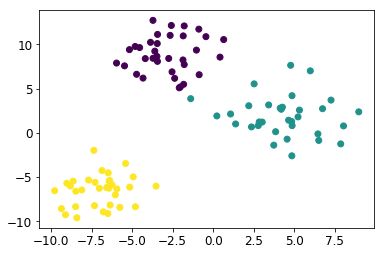

In [4]:
from sklearn.datasets import make_blobs

X, y = make_blobs(centers=3, n_features=2, n_samples=100, cluster_std=[2.0, 2.3, 1.8], random_state=42)
plt.scatter(X[:,0], X[:,1], c=y)

xx, yy = get_meshgrid(X[:, 0], X[:, 1], nx=100, ny=100, margin=0.1)

In [5]:
def plot_predicted_label(ax, clf, xx, yy, X, t):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.7)
    ax.scatter(X[:,0], X[:,1], c=t, edgecolor='k')
    
def plot_prob_density(ax, model, xx, yy, X, t):
    Z = model.calc_prob_density(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.scatter(X[:,0], X[:,1], c=t, edgecolor='k')
    ax.contour(xx, yy, Z)
    
def plot_result(model, xx, yy, X, t):
    fig = plt.figure(figsize=(8,4))
    ax = fig.add_subplot(121)
    plot_predicted_label(ax, model, xx, yy, X, t)
    ax = fig.add_subplot(122)
    plot_prob_density(ax, model, xx, yy, X, t)

## 4.2 Results for $K=3$

n_iter : 23
log_likelihood : -515.3221954638727


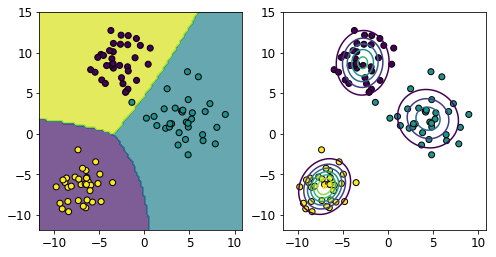

In [6]:
gmm = GaussianMixtureModel(K=3)
gmm.fit(X, max_iter=30, tol=1e-4, disp_message=True, random_state=0)

plot_result(gmm, xx, yy, X, y)

We can see that the data is properly clustered as we expect intuitively. 
However, depending on the initialization of model parameters, different results can be obtained, as follows:

n_iter : 29
log_likelihood : -533.6831531127243


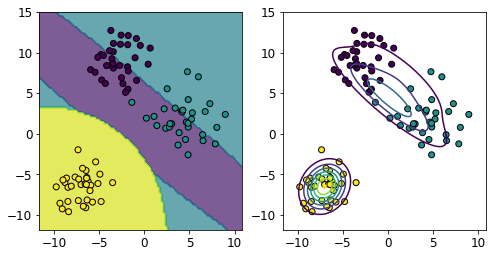

In [7]:
gmm = GaussianMixtureModel(K=3)
gmm.fit(X, max_iter=30, tol=1e-4, disp_message=True, random_state=1)
plot_result(gmm, xx, yy, X, y)

However, we can see that the former result has larger log-likelihood, and thus it is more appropriate to choose the former result. In reality, we should run fitting several times with different initialization, and choose the result with largest log-likelihood.

## 4.3 Results for different valeus of $K$

The result for various $K$ are shown below.

K = 2
n_iter : 18
log_likelihood : -562.7613810500463


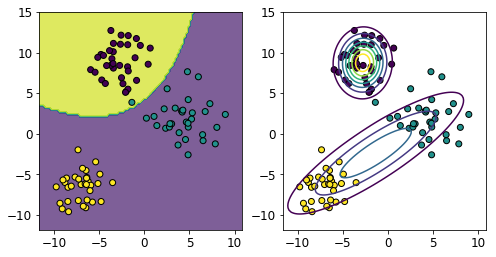

K = 4
n_iter : 50
log_likelihood : -511.2771065710105


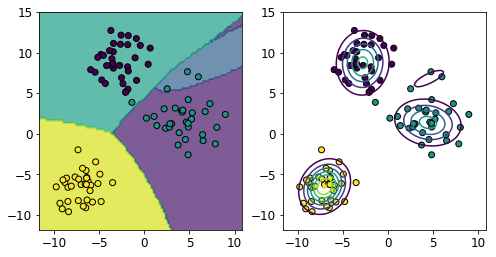

K = 10
n_iter : 115
log_likelihood : -483.17586164025226


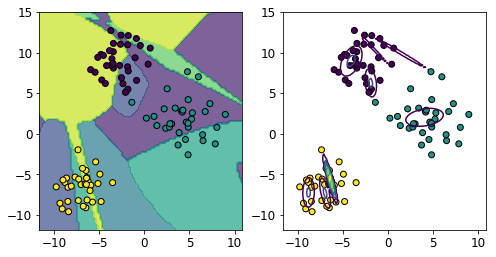

In [8]:
for K in [2, 4, 10]:
    print(f"K = {K}")
    gmm = GaussianMixtureModel(K=K)
    gmm.fit(X, max_iter=1000, tol=1e-4, disp_message=True, random_state=0)
    plot_result(gmm, xx, yy, X, y)
    plt.show()